##### Chapter 2: Training Simple Machine Learning Algorithms for Classification

We will use 2 of the first described ML algorithms, the perceptron and adaptive linear neaurons. We will implement a perceptron to classify the flowers in the Iris dataset into species classes. Basics of optimization will then be explored using adaptive linear neaurons to lay the ground work for more sophisticated classifiers provided by scikit-learn.

### Formal definition of an artificial neauron

We put the idea of an artificial neauron into context using a binary classifcation where there are 2 classes, 0 and 1. We define a decision function $\sigma (z)$ that takes a linear combination of certain input values $x$, and a corrsonding weight vector $w$ where $z$ is the so called net input $z = w_1x_1 + w_2x_2 + ... + w_mx_m$

\begin{equation}
    w = \begin{bmatrix} W_1 
        \\ . 
        \\ . 
        \\ . 
        \\ W_m 
        \end{bmatrix} , x = \begin{bmatrix} X_1 \\ . \\ . \\ . \\ X_m \end{bmatrix}
\end{equation}



If the net input of a particular example $x^{i}$ is greater than the defined threshold $\theta$ we predict the class 1, otherwise 0. In the perceptron algorithm the decision function $\sigma (.)$ is a variant of the unit step function:

\begin{equation}
    \sigma (z) = \begin{cases}
        1 & if\ z >= \theta \\
        0 & otherwise
        \end{cases}
\end{equation}

To simplify code implimentation later we modify this sllightly by bringing $\theta$ across to the left:
$$
    z >= \theta \\ z - \theta >= 0
$$
Then we define a unit bias $b = -\theta$ and include it in the net input:
$$
z = w_1x_1 + ... + w_mx_m + b = \bf{w}^{T}\bf{x}+b
$$
Third, given the introduction of the unit bias and redefinition of the net input $z$ above we can redefine the decision function as follows:
$$
\sigma (z) = \begin{cases} 1 & if\ z>=0\\0 & otherwise \end{cases}
$$

<p style="text-align: center;">
<img src="Figures\02_02.png" width="800" height="400">
</p>
<p style="text-align: center;"><b>Figure 2.2: A thrshold function that produces a linear decision boundary for a binary classification</b></p>

Figure 2.2 shows how the net input $z = \bf{w}^{T}\bf{x} + b$ is swuashed into a binary 1 or 0 output by the decision function of the perceptron (left) and how it can be used to discriminate between 2 classes seperated by a linear decision boundary (right subfigure).

### The perceptron learning rule

The whole idea is to use a reductionist approach to mimic how a single neauron in the brain works, it either fires or it doesn't. The perceptron algorithm can be summerized by the following steps

1. Initialise the weights and bias unit to 0 or small random numbers
2. For each training example, $\bf{x}^{(i)}$:
 * Compute the output value, $\hat{y}^{(i)}$
 * Update the weight and bias units

 Here the output value is the class label predicted by the Heviside function and the simultaneous update of the bias unit and each weight can be formally written as:

$$
w_j := w_j + \Delta w_j \\ b := b + \Delta b
$$
The update values "deltas" are computed as:
$$
\Delta w_j = \eta(y^{(i)} - \hat{y}^{(i)})x_j^{(i)}\\
\Delta b = \eta(y^{(i)} - \hat{y}^{(i)})
$$
Each weight is associated with a feature $x_j& in the dataset which is used in calculating the correction to $w_j$. $\eta$ is the learning rate, typically a value $\epsilon [0.0, 1.0]$, $y^{(i)}$ is the true class label of the ith training example and $\hat{y^{(i)}}$ is the predicted class. All the updates are done simultaneously meaining we dont recompute the predicted label before the bias unit and all weights are updated.

The convergence of the perceptron is not guarenteed however, if the two classes are not linearly seperable then a clean straight line cannot be drawn between them and the weights and biases will not converge to a constant value because there will always be some training examples that get mislabelled, and therefore the weights and biases will always get updated by some non-zero value. Figure 2.3 shows this diagramatically.


<p style="text-align: center;">
<img src="Figures\02_03.png" width="800" height="400">
</p>
<p style="text-align: center;"><b>Figure 2.3: Example of a linearly seperable problem and 2 non-linearly seperable problems</b></p>

If 2 classes are not linearly seperable then we can define either a max number of epochs to iterate and train over or a max number of acceptable mislabelled training examples, doing so for non-linearly seperable classes will ensure that the algorithm will converge or cease training even if it sees there are still some mislabelled training examples. We will later see an example algorithm call the Adaline algorithm which achieves convergence even when the dataset looks like subfigures 2.3a or 2.3b. There are more advanced algorithms which can produce non-linear decision boundaries which will also be covered later.

<p style="text-align: center;">
<img src="Figures\02_04.png" width="800" height="400">
</p>
<p style="text-align: center;"><b>Figure 2.4: Summary of the learning process for the perceptron</b></p>

### Implementing the perceptron in python 3.9

We will implement a perceptron tailored around the iris dataset touched upon in chapter 1.

### An object oriented perceptron API

We will define the perceptron interface as a python class which allows new perceptrons objects to be initialised that can learn from the data via a fit method and make predictions via a seperate predict method. As a convention we append an underscore (\_) ti attributes that are not created upon initialisation of the object, but we do this by calling the objects other methods, for example self.w_.

In [2]:
import numpy as np

class Perc:
    """
    Perceptron Classifier.

    Parameters
    ----------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        number of passes over the training dataset
    random_state: int
        Random number generation seed for random weight initialisation

    Attributes
    ----------
    w_ : 1d-array
        Weights after fitting
    b_ : Scalar
        Bias unit after fitting
    
    errors_ : list
        Number of misclassifications (updates) in each epoch

    """

    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
    
    def fit(self, X, y):
        """
        Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
            Training vectors, where n_examples is the number of examples and n_features is the number of features
        y : array-like, shape = [n_examples]
            Target values
        
        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        self.b_ = np.float_(0.)
        self.errors_ = []
        for i in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w_ += update * xi
                self.b_ += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self
    
    def net_input(self, X):
        """Calculate the net input"""
        return np.dot(X, self.w_) + self.b_
    
    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, 0)

We can now initialize new perceptrons with a given learning rate and number of epochs. Using the fit method we initialize the bias self.b_ to an initial value of 0 and weights nself.w_ to a vecotr $\mathbb{R}^m$ where m is the number of dimensions or features. Weights are initialized with a small random number drawn from the normal distribution via the rgen.normal(loc=0.0, scale = 0.01, size = 1 + X.shape[1]) which produces these small random numbners in a reproduciuble way. If we initialized the weights to 0 the learning rate would not affect the decision boundary, it would only affect the scale of the weight vectore and not its direction.

After initiliazation the fit method calls the predict method while looping over all the examples in the training dataset and updates the weights accordingly. The predict method will also be the method used to predict new labels on the test dataset after fitting the model. We collect the number of misclassifications during each epoch in the self.errors_ method list fo we can analyse the perceptron performance during training.

##### Training a perceptron model on the Iris dataset

We will restrict this example to 2 flower classes features of the dataset since the model is a binary classifier and we wish to visualise the decision boundary on a 2D graph. We can extend the implementation of the perceptron to an arbitrary number of classes using the One Vs All approach which uses perceptrons to determine if a given example fits into a certain class, or whether it more likely fits into any of the other possible classes. By having a perceptron for each class the perceptron can be used beyond binary classification.

We load the Iris dataset using the pandas library

In [3]:
import os
import pandas as pd
pd.options.display.max_seq_items = 2000
s = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'

df = pd.read_csv(s, header=None, encoding='utf-8')
df.tail(5)

,0,1,2,3,4
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


2


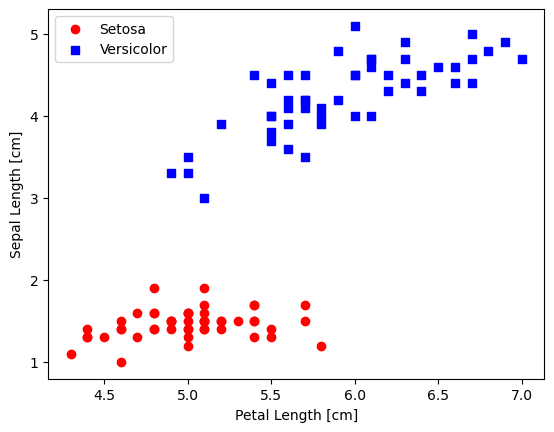

,0,1
0,5.1,1.4
1,4.9,1.4
2,4.7,1.3
3,4.6,1.5
4,5.0,1.4


In [4]:
# Extract the first 100 class labels corresponding to the 50 Iris-setosa and 50 Iris-versicolour flowers and conver the class labels into two integer class labels, 0 and 1 respectively

import matplotlib.pyplot as plt
import numpy as np

y = df.iloc[0:100, 4].values
y = np.where(y == 'Iris-setosa', 0, 1)

# Extract sepal length feature

X = df.iloc[0:100, [0,2]].values
print(X.shape[1])

# Plot the data

plt.scatter(X[:50, 0], X[:50, 1], color='red', marker='o', label = 'Setosa')
plt.scatter(X[50:100, 0], X[50:100, 1], color='blue', marker='s', label='Versicolor')
plt.ylabel('Sepal Length [cm]')
plt.xlabel('Petal Length [cm]')
plt.legend(loc='upper left')
plt.show()

x_df = pd.DataFrame(X)
x_df.head()

Figure 2.6: Scatter plot of the setosa and versicolour flowers by sepal and petal length.

In fig 2.6 we can see visually that a linear decision boundary should be sufficient to separate the 2 flower types based on only these 2 features of the dataset. Thus a linear binary classifier such as the perceptron should be sufficient for this problem. We will now train our perceptron algorithm on the subset we have extracted and plot the misclassification at each epoch to check whether the algorithm converged and found a decision boundary.

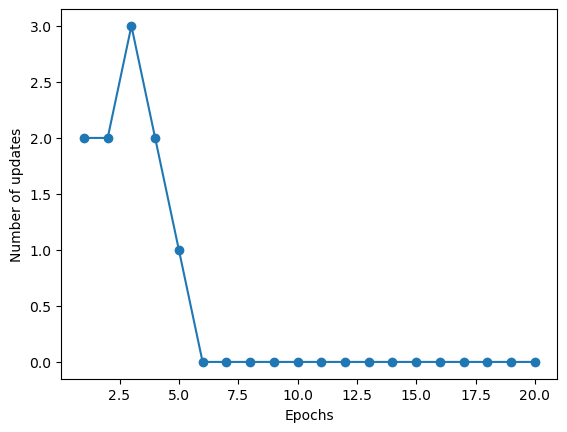

In [5]:
ppn = Perc(eta=0.1, n_iter=20)
ppn.fit(X, y)
plt.plot(range(1, len(ppn.errors_)+1), ppn.errors_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Number of updates')
plt.show()

Fig 2.7: A plot of the number of errors/updates at each epoch

The number of updates and errors are the same since the perceptron algorithm only updates the weights and bias terms when there is a misclassifcation. After 6 epochs the algorithm converged and stopped misclassifying the flowers. We can write a function to visualise the decision boundary.

('red', 'blue')
3.3 8.0 

0.0 6.1 



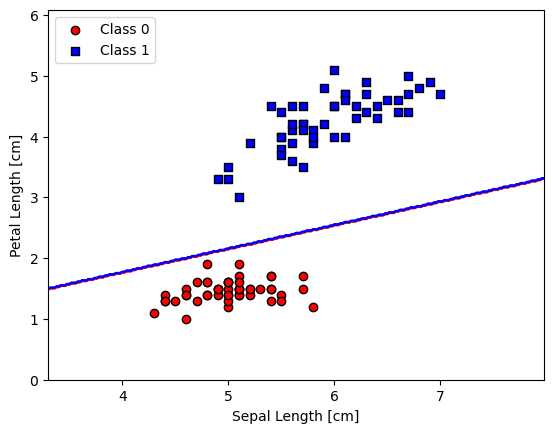

In [6]:
from matplotlib.colors import ListedColormap
def plot_decision_boundary_regions(X, y, classifier, resolution=0.02):
    # setp marker generator and colour map
    markers = ('o', 's', '^', 'v', '<')
    colours = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colours[:len(np.unique(y))])
    print(colours[:len(np.unique(y))])

    #plot the decision surface

    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    print(x1_min, x1_max,'\n')
    print(x2_min, x2_max,'\n')
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contour(xx1, xx2, lab, alpha=0.8, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    for i, cl, in enumerate(np.unique(y)):
        plt.scatter(x=X[y==cl,0], y=X[y==cl,1],alpha=1, color=colours[i], marker=markers[i], label = f'Class {cl}', edgecolor='black')

plot_decision_boundary_regions(X, y, classifier=ppn)
plt.xlabel('Sepal Length [cm]')
plt.ylabel('Petal Length [cm]')
plt.legend(loc='upper left')
plt.show()

##### Adaptive linear neurons and the convergence of learning

We now look at a different type of single layer neural network, ADAptive LInear NEuron (Adaline), which outlines key concepts of defining and minimizing continuous loss functions, thereby laying the ground work for other machine learning algorithms for classification, such as logistic regression, support vector machinesand multi layer neural networks as well as linear regression models.

The key difference between the Adaline and perceptron models is that the weights in the Adaline model are updated based on a linear activation function rather than a unit step function used by the perceptron. In Adaline, this linear activation function $\sigma(z)$ is simply the identity function of the net input, $\sigma(z) = z$

While the linera activation function is used for determining the weights the final prediction is still determined by a threshold function similar to the unit step function convered earlier.

<p style="text-align: center;">
<img src="Figures\02_09.png" width="800" height="650">
</p>
<p style="text-align: center;"><b>Figure 2.9: Comparison between a perceptron and Adaline algorithm</b></p>

Figure 2.9 shows how the Adaline algorithm compares the true class labels with the linear activation functions continous valued output to compute the model error and update the weights, in contrast the perceptron compares the true class labels vs the predicted class labels.

### Minimizing the loss function

One of the key ingedients of supervised machine learning algorithms is a defined <b>objective function</b> that is to be optimized during the learning prcocess, often a loss or cost function that we want to minimize. In Adaline, we can define the loss function <b>L</b>, to learn the model parameters as the <b>mean squared error (MSE)</b> between the calculated outcome and the true class label:

$$
L(\bf{w},b) = \frac{1}{n}\sum_{i=1}^{n}(y^{(i)} - \sigma(z^{(i)}))^{2}
$$

The main advantage of this continuous linear activation function is that the loss function becomes differentiable. Also, it has the property that it is convex so we can use the powerful gradient descent technique to find the weights that minimize our loss function to classify examples. Fig 2.10 illustrates this algorithm's main idea as climbing down a hill until a local or global loss minimum is reached. In each iteration we take a step in the opposite direction of the gradient, where the step size is determined by the value of the learning rate, as well as the slope of the gradient. The figure shows this for a single weight only for simplicity.

<p style="text-align: center;">
<img src="Figures\02_09.png" width="800" height="650">
</p>
<p style="text-align: center;"><b>Figure 2.10: Gradient Descent</b></p>

We can update the model parameters by taking a step in the opposite direction of the gradient $\nabla L(\bf{w},b)$ of our loss function $L(\bf{w},b)$:

$$
\bf{w}: = \bf{w} + \Delta \bf{w}, b: = b + \Delta b
$$

We define the changes to the weight and bias terms as the negative gradient multiplied by the learning rate $\eta$

$$
\Delta w = -\eta \nabla_w L(w, b), \Delta b = -\eta \nabla_b L(w, b)
$$

To compute the gradient of the loss function we need to compute $\nabla_w$ which requires the partial derivative of the loss function w.r.t each weight term $w_j$:
$$
\frac{\partial{L}}{\partial{w_j}} = -\frac{2}{n}\sum_i(y^{(i)} - \sigma(z^{(i)}))x_j^{(i)}
$$

We compute the partial derivatives w.r.t the bias terms in a similar way

$$
\frac{\partial{L}}{\partial{b_j}} = -\frac{2}{n}\sum_i(y^{(i)} - \sigma(z^{(i)}))
$$

The factor of 2 can be omitted, it is purely a scaling factor born out of the derivative obtained when differentiating using the product rule and has the same affect as modifying the learning rate by a factor of 2.

We can write the update equations as:

$$
\Delta w_j = -\eta \frac{\partial{L}}{\partial{w_j}}, \Delta b_j = -\eta \frac{\partial{L}}{\partial{b_j}}
$$

Since we are updating all the weights and bias terms at once we can write the Adaline learning rule as:

$$
\textbf{w}:=\textbf{w}+\Delta \textbf{w}, b:= b + \Delta b
$$

Although the Adaline learning rule looks the same as the perceptron rule, we should note that $\sigma (z^{(i)})
$ with $z^{(i)} = \textbf{w}^T\textbf{x}^{(i)} + b$ is a real number and not an integer class label. Furthermore, the weight update is calculated based on all training examples instead of updating the parameters incrementally after each training example, which is why this approach is referred to as Batch Gradient Descent, or more specifically Full Batch Gradient Descent.

### Implementing Adaline in Python

Since the perceptron rule and Adaline are very similar, we will take the perceptron implementation we defined earlier and chane the fit method so that the weight and bias parameters are now updated by minimizing the loss function via gradient descent:

In [7]:
class AdalineGD:
    '''ADAptive LInear NEuron
    
    Parameters
    ----------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset
    random_state : int
        Random number generator seed for random weight initialization
    
    Attributes
    ----------
    w_ : 1d-array
        Weights after fitting
    b_ : 1d-array
        Bias unit after fitting
    losses_ : list
        Mean squared error loss function values in each epoch
    '''
    def __init__(self, eta=0.1, n_iter=50, random_state=1):
        self.eta_ = eta
        self.n_iter = n_iter
        self.random_state = random_state
    
    def fit(self, X, y):
        ''' Fit the training dataset
        
        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
            Training vectors, where n_examples is the number of training examples and n_features is the number of training features
        
        y : arary-like, shape = [n_examples]
            Target Values
        
        Returns
        -------
        self : object
        '''
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.1, size=X.shape[1])
        self.b_ = np.float_(0.)
        self.losses_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_ += self.eta_ * 2 * X.T.dot(errors) / X.shape[0]
            self.b_ += self.eta_ * 2 * errors.mean()
            loss = (errors**2).mean()
            self.losses_.append(loss)
        return self
    
    def net_input(self, X):
        ''' Calculate the net input '''
        return np.dot(X, self.w_) + self.b_
    
    def activation(self, X):
        ''' Compute Linear activation'''
        return X
    
    def predict(self, X):
        ''' Return class label after unit step'''
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

In practice it often requires experimentation to find good hyperparamters eta and n_iter. Lets choose 2 learning rates $\eta$ = 0.1 and $\eta$ = 0.0001 and plot the loss functions vs the number of epochs to see how well the Adaline implementation learns from the training data.

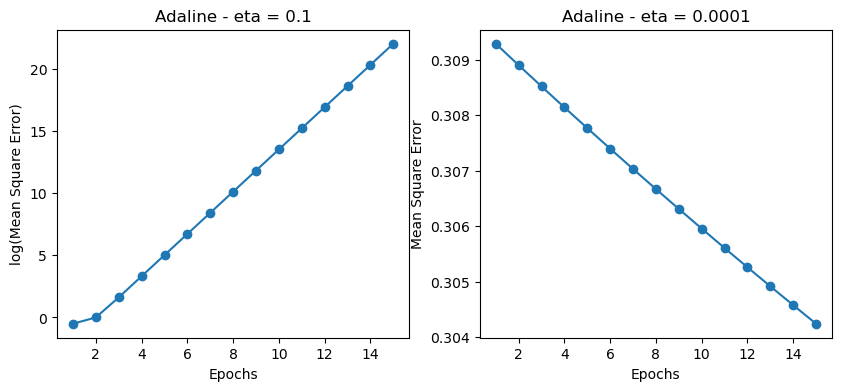

In [8]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
ada1 = AdalineGD(n_iter=15, eta=0.1).fit(X, y)
ax[0].plot(range(1, len(ada1.losses_) + 1), np.log10(ada1.losses_), marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('log(Mean Square Error)')
ax[0].set_title('Adaline - eta = 0.1')

ada2 = AdalineGD(n_iter=15, eta=0.0001).fit(X, y)
ax[1].plot(range(1, len(ada2.losses_) + 1), ada2.losses_, marker='o')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Mean Square Error')
ax[1].set_title('Adaline - eta = 0.0001')
plt.show()



<p style="text-align: center;">
<img src="Figures\02_12.png" width="800" height="300">
</p>
<p style="text-align: center;"><b>Figure 2.12: A comparison of a poorly chosen learning rate causing a logarithmic increase in the mean squared error and a well chosen learning rate which decreases the mean square error and will eventually comverge on the minimum</b></p>

### Improving gradient descent through feature scaling

The algorithms described throughout will require some level of feature scaling in order to perform most optimally and gradient descent benefits from feature scaling too. We will use a feature scaling method called <b> standardization </b>. This normalization procedure does not transform each feature into a normal distribution, but instead shifts the mean of each feature to be centred at 0 with a unit standard deviation. 

To standardize an arbitrary feature from a dataset, feature j, we can subtract the mean and divide by the standard deviation:

$$
x^`_j = \frac{x_j-\mu_j}{\sigma_j}
$$

Where x_j is the vector containing all the values of the jth feature. This works well for gradient descent by ensuring that all features are on similar scales. Without standardization you may have instances where a given learning rate is too small for updating one weight quickly enough, but too large for adjusting another weight. Overall, it reduces the number of steos the optimizer has to go through to find a good or optimal solution (the global loss minimum).

Figure 2.13 shows gradient descent updates with unscaled (left) and scaled (right) features, the concentric circles represent the loss surface as a function of 2 model weights in a 2D classification problem.

<p style="text-align: center;">
<img src="Figures\02_13.png" width="600" height="400">
</p>
<p style="text-align: center;"><b>Figure 2.13: A comparison of unscaled and standardized features on gradient updates</b></p>

Standardization can easily be done using the numpy library:

In [9]:
X_std = np.copy(X)
X_std[:,0] = (X[:,0] - X[:,0].mean() ) /X[:,0].std()
X_std[:,1] = (X[:,1] - X[:,1].mean() ) /X[:,1].std()

After doing this standardization we retrain the Adaline model and see that it converges after a small number of epochs even with a large learning rate of $\eta$ = 0.5

('red', 'blue')
-2.834038202541543 3.394743306307442 

-2.291886060781545 2.552761011830878 



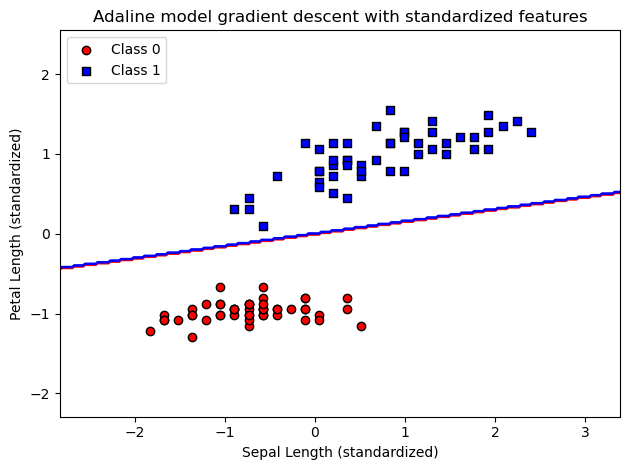

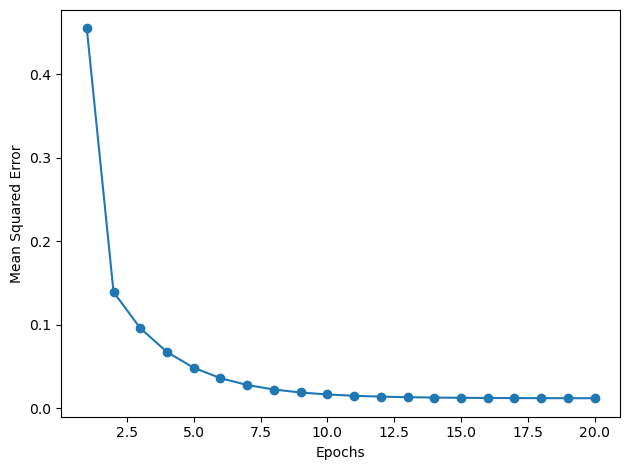

In [10]:
ada_gd = AdalineGD(n_iter=20, eta=0.5).fit(X_std, y)
plot_decision_boundary_regions(X_std, y, classifier=ada_gd)
plt.title('Adaline model gradient descent with standardized features')
plt.xlabel('Sepal Length (standardized)')
plt.ylabel('Petal Length (standardized)')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()
plt.plot(range(1, len(ada_gd.losses_) + 1 ), ada_gd.losses_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.tight_layout()
plt.show()

We can see in the plots that the Adaline model has converged but the mean square error is still non-zero despite all the flowers being correctly classified.

### Large-scale ML and stochastic gradient descent

A large dataset with millions or billions of examples in the training dataset does not lend itself to full batch gradient descent, it would be very costly computationally and/or take a long time to train. <b> Stochastic Gradient Descent (SGD)</b> is a popular alternative to full batch gradient descent. Instead of updating the weights based on the sum of the accumulated errors over all training examples we update the parameters incrementally after each training example. Full batch gradient descent:

$$
\Delta w_j = -\eta \frac{\partial{L}}{\partial{w_j}} = -\frac{2\eta}{n}\sum_i(y^{(i)} - \sigma(z^{(i)}))x_j^{(i)}
$$
SGD:
$$
\Delta w_j = \eta(y^{(i)}-\sigma(z^{(i)}))x_j^{(i)}\newline \Delta b = \eta(y^{(i)}-\sigma(z^{(i)}))
$$
Altough SGD is an approximation of gradient descent it often converges much faster on a minimum due to the more frequent updates to the parameters. Since each gradient is calculated based on a single training example, the error surface is much noisier than full batch gradient descent, which also mean SGD has the advantage of being able to escape shallow local minima in the loss function if working with a non-linear loss function. It is important though, to present training data in a random order when doing SGD; also, we want to shuffle the training dataset for each epoch to prevent cycling update changes and getting our parameters stuck in a loop.

In SGD the learning rate $\eta$ is often replaced with an adaptive learning rate that decreases over time:

$$
\frac{c_1}{[number of iterations] - c_2}
$$

Where c_{1,2} are constants. Note, SGD does not reach a global loss minimum but an area very close to it, and an adaptive learning rate helps get closer to the global minimum.

Another advantage of SGD is its application in <b>online learning</b>, wjere our model can be trained on the fly as new training examples arrive, useful when accumulating large amounts of data for example customer data in web-applications. Online learning allows a model to immediately adapt to changes and training data can be discarded if storage space is an issue/consideration.

# Mini-batch gradient descent

A compromise between full batch GD and SGD, mini batch GD is when FBGD is applied to a smaller subset of the training dataset. More frequent updates to model parameters (like SGD) helps the model to converge faster, but also removes the need for the for loop used in SGD, and allows vecotrization algorithms to be used to improve computational efficiency.

### Implementing SGD on the Adaline model.

Only a few adjustments are required to modify the learning algorithm to updates weights via SGD. Inside the fit method we will update weights after each training example and also add a partial_fit method which does not initialize the weghits for use in online learning. To check for convergence after training we will calculate the loss as the average loss of the training examples in each epoch. Furthermore, we will add an option to shuffle the data before each epoch.

In [11]:
class AdalineSGD(AdalineGD):
    '''
    ADAptive LInear Neuron Classifier using stochastic gradient descent.
    
    Child class of AdalineGD

    Child Parameters
    ----------------
    shuffle : bool
        Control parameter used to shuffle training dataset if True to prevent cycles
    '''

    def __init__(self, n_iter=15, eta = 0.01, shuffle=True, random_state=None):
        super().__init__(eta=eta, n_iter=n_iter)
        self.w_inited = False
        self.shuffle = shuffle
    
    def fit(self, X, y):
        ''' Fit training data
        
        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]

        y : array-like, shape = [n_examples]

        Returns
        -------

        self : object
        '''
        self._initailise_weights(X.shape[1])
        self.losses_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            losses = []
            for xi, target in zip(X, y):
                losses.append(self._update_weights(xi, target))
            avg_loss = np.mean(losses)
            self.losses_.append(avg_loss)
        return self
    
    def partial_fit(self, X, y):
        '''Fit training data without initializing weights'''
        if not self.w_inited:
            self._initialise_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self

    def _shuffle(self, X, y):
        r = self.rgen.permutation(len(y))
        return X[r], y[r]
    
    def _initailise_weights(self, m):
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.1, size = m)
        self.b_ = np.float_(0.)
        self.w_inited = True
    
    def _update_weights(self, xi, target):
        output = self.activation(self.net_input(xi))
        error = (target - output)
        self.w_ += self.eta_ * 2 * xi * error
        self.b_ += self.eta_ * 2 * error
        loss = error**2
        return loss

The shuffle method works by using the numpy.random.permutation function the generate a random sequence of unique numbers in the range 0 to 100 which can then be used as indicies to shuffle our feature matrix and class label vector.

('red', 'blue')
-2.834038202541543 3.394743306307442 

-2.291886060781545 2.552761011830878 



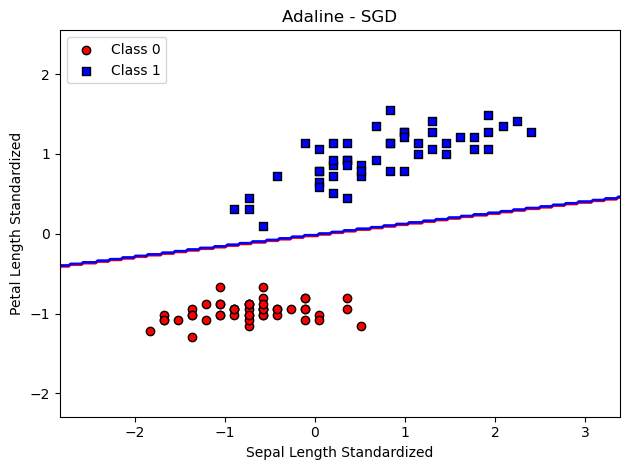

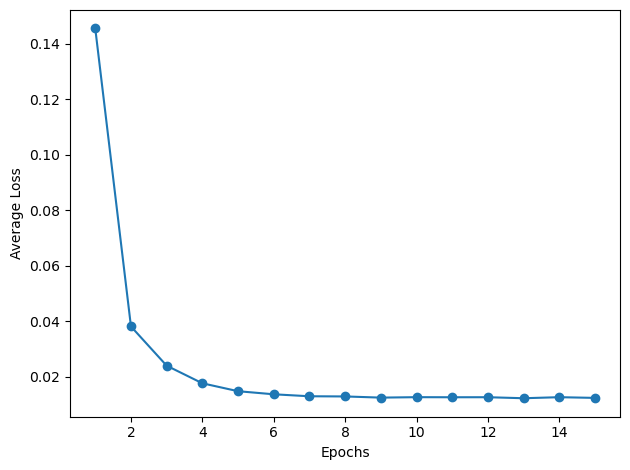

In [12]:
ada_sgd = AdalineSGD(n_iter=15, eta=0.01, random_state=1)
ada_sgd.fit(X_std, y)
plot_decision_boundary_regions(X_std, y, classifier=ada_sgd)
plt.title('Adaline - SGD')
plt.xlabel('Sepal Length Standardized')
plt.ylabel('Petal Length Standardized')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()
plt.plot(range(1, len(ada_sgd.losses_)+1), ada_sgd.losses_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Average Loss')
plt.tight_layout()
plt.show()

The average loss goes down quite quickly, and looks similar to the batch gradient descent Adaline. If we want to update our model, for example, in an online learning scenario with streaming data, we could simply call the partial_fit method on individual training examples - for instance ada_sgd.partial_fit(X_std[0, :], y[0])

##### Summary

In this chapter we looked at the core concepts of linear classifiers for supervised learning, after implementing a perceptron, we saw how we can train adaptive linear neurons efficiently via a vectorized implementation of gradient descent and online learning via SGD.

In the next chapter we will use the scikit-learn ML library to get access to more advanced and powerful ML classifiers which still use the opbject oriented approach to implementation with the fit and predict methods. Based on these core concepts we will learn about logistic regression for modelling class probabilities and support vector machines for working with non-linear decision boundaries. We will also introduce a differen class of supervised learning algorithms, tree-based algorithms, which are commonly combined into robust ensemble classifiers.